In [1]:
import os as os
os.chdir(r'C:\Users\falco\Desktop\directory\Cattle_AMR_2')
data_path = r'C:/Users/falco/Desktop/directory/Cattle_AMR_2/data/'
output_path = r'C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/'

import sklearn
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold ,cross_val_score, train_test_split, cross_val_predict
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve
#from pandas_ml import ConfusionMatrix
import re
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.style as style

import pandas.api.types as pdtypes

from plotnine import *
from plydata import *

np.random.seed(1234)
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from functions import functions as f


style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1
dpi = 1000
plt.rcParams['font.size'] = 13
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
plt.rcParams['axes.titlesize'] = 1.5*plt.rcParams['font.size']
plt.rcParams['legend.fontsize'] = plt.rcParams['font.size']+1
plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
plt.rcParams['figure.figsize'] = 8, 8
import warnings
warnings.filterwarnings('ignore')

### Commensals resistance

In [2]:
%%time
data, d = f.read_process_data(data_path=data_path)

reading datafile
fill missing values and correct some values
changing the column names
generating output variables
final R_factor output
1    213
0     30
Name: Penicillin, dtype: int64
1    213
0     30
Name: Ceftiofur, dtype: int64
0    204
1     39
Name: Tetracycline, dtype: int64
Wall time: 1.63 s


In [3]:
data.Antibiotic1.value_counts()

Penicillin       121
Ceftiofur         92
None_reported     30
Name: Antibiotic1, dtype: int64

In [4]:
data.Antibiotic2.value_counts()

Penicillin       122
Ceftiofur         91
None_reported     30
Name: Antibiotic2, dtype: int64

In [5]:
data.Antibiotic1.value_counts()

Penicillin       121
Ceftiofur         92
None_reported     30
Name: Antibiotic1, dtype: int64

In [6]:
data.filter(like = 'ID').head()

,Dairy ID,MT_Results Individual_CowID,SampleID2,F_AMR_CowID,CowID
0,CA005,4672,NaN,NaN,4672
1,CA005,1099,NaN,NaN,1099
2,CA005,3786,NaN,NaN,3786
3,CA005,3596,NaN,NaN,3596
4,CA005,4880,NaN,NaN,4880


# Model Predictors

In [7]:
herd_parameters = [
    'HerdSize', 
    'RollingHerdAvg', 
    'Holstein',
    'Jersey',
    'CullPctMonth',
    'CullTimesMonth',
    'MainCullReason',
    'PctCullBeef',
    'PctCullCondemned',
    'PctInject',
    'VetTreats',
    'ManagerTreats',
    'StaffTreats',
    'ResiduePrevent',
    'Chalk4Withdrawal',
    'Inventory',
    'SeparateUse',
    'CombinationUse',
    'TrackAntibioticDose',
    'TrackAntibioticRoute',
    'FamiliarELDU',
    'FreqELDU',
    'NoELDU',
    'NumberCulled',
    'SalmonellaVaccine'
]

In [8]:
cow_parameters = ['LowMilkCull',
                  'ReproCull',
                  'LameCull',
                  'MastitisCull',
                  'OtherCull',
                  'AMD',
                  'Ani-Inf',
                  'No-Treatment',
                  'Other',
                  'Tetracycline',
                  'Penicillin',
                  'Ceftiofur',
                  'Season'
]

In [9]:
categorical = ['CullTimesMonth',
               'PctCullCondemned',
               'PctInject',
               'FreqELDU',
               'Season'
               ]

In [10]:
features = cow_parameters+ herd_parameters
len(features)

38

In [11]:
len(herd_parameters)

25

In [12]:
len(cow_parameters)

13

In [13]:
data.R_factor.value_counts()

1    107
2     75
0     61
Name: R_factor, dtype: int64

In [14]:
data.Holstein.value_counts()

100    122
97      40
0       40
40      20
36      11
38      10
Name: Holstein, dtype: int64

### Salmonella resistance

In [15]:
data.Sal_R.value_counts()

0    218
1     20
2      5
Name: Sal_R, dtype: int64

### E.coli resistance

In [16]:
data['Ecoli_R'].value_counts()

0    162
1     74
2      7
Name: Ecoli_R, dtype: int64

### Entero resistance 

In [17]:
data['Entero_R'].value_counts()

1    92
0    86
2    65
Name: Entero_R, dtype: int64

In [18]:
data['Commensal_R'].value_counts()

1    90
2    87
0    66
Name: Commensal_R, dtype: int64

In [19]:
from model_functions import *
from xgboost import XGBClassifier
from pdpbox import pdp, get_dataset, info_plots
from xgboost import plot_importance

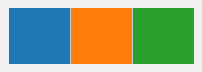

In [20]:
sns.palplot(sns.color_palette("tab10", 3))

## Feature importance and Partial Dependence

### SHAP values
SHAP (SHapley Additive exPlanations).  
SHAP assigns each feature an importance value for a particular prediction as unified measure of feature importance based on various methods.   
SHAP values attribute to each feature the change in the expected model prediction when conditioning on that feature. 

In [21]:
def get_importance(data, y, analysis_name, color_list, clf):
    ## processing categorical variables for training and testing data
    from sklearn import preprocessing
    
    for c in categorical:
        print(c)
        le = preprocessing.LabelEncoder()
        le.fit(data[c])
        data[c] = le.transform(data[c]) 
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(le_name_mapping)
        
    #best_xgb = XGBClassifier(learning_rate= 0.1, colsample_bytree= 0.3, max_depth= 4, gamma= 0.4, min_child_weight= 1)
    #best_xgb = XGBClassifier(learning_rate= 0.1, colsample_bytree= 0.4, max_depth= 1, gamma= 0.2, min_child_weight= 3)
    #best_xgb = XGBClassifier(colsample_bytree= 0.4, gamma= 0.8, learning_rate= 0.5,
    #                         max_depth= 4, min_child_weight= 3,
    #                         n_estimators= 3, objective= 'multi:softprob')
    best_xgb = clf
    X_train, X_test, y_train, y_test = train_test_split(data[cow_parameters+ herd_parameters], data[y], test_size=0.33, random_state=42)
    print ('Fitting started')
    xgb = best_xgb.fit(X = data[cow_parameters+ herd_parameters], y = data[y])
    import shap
    # this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
    explainer = shap.TreeExplainer(xgb)
    shap_values = explainer.shap_values(data[cow_parameters+ herd_parameters])
    from matplotlib.colors import ListedColormap
    colors = color_list 
    plt.rcParams['axes.labelsize'] = 15
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    c = ListedColormap(sns.color_palette(colors).as_hex())
    fig  = shap.summary_plot(shap_values, data[cow_parameters+ herd_parameters], plot_type="bar",color=c, show=False)
    L=plt.legend()
    #L.get_texts()[0].set_text('MDR')
    #L.get_texts()[1].set_text('No resistance')
    #L.get_texts()[2].set_text('AMR')
    plt.tight_layout()
    plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/'+analysis_name+'_XgBoost_imp_SHAP.svg')
    plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']

### all data

0 = green  = #66c2a5  
1 = blue = #8da0cb  
2 = orange = #fc8d62  

In [22]:
all_clf = XGBClassifier(colsample_bytree= 0.1, gamma= 0.5, learning_rate= 0.05,
                        max_depth= 7, min_child_weight= 7,
                         n_estimators= 30, objective= 'multi:softprob')

CullTimesMonth
{'0': 0, '1': 1, '1-2': 2, '1-3': 3, '1-4': 4, '2-4': 5, '4': 6}
PctCullCondemned
{'0': 0, '<1': 1, '<1-3': 2, '<10': 3}
PctInject
{'0': 0, '10': 1, '10-20': 2, '<10': 3, '~10': 4, '~20': 5, '~30': 6}
FreqELDU
{'0': 0, '1-2': 1, '10-20': 2, '2-5': 3, '21': 4, 'Variable': 5, '~5': 6}
Season
{'Autumn': 0, 'Spring': 1, 'Summer': 2, 'Winter': 3}
Fitting started


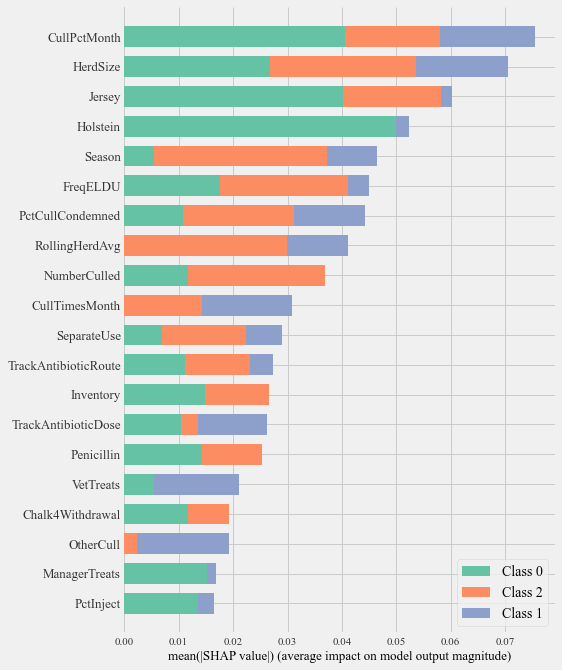

In [23]:
get_importance(data=data, y='R_factor', analysis_name='All_cows', color_list = ['#66c2a5', '#fc8d62', '#8da0cb'], clf = all_clf)

In [24]:
commensal_clf = XGBClassifier(colsample_bytree= 0.4, gamma= 0.6, learning_rate= 0.5,
                        max_depth= 7, min_child_weight= 1,
                         n_estimators= 3, objective= 'multi:softprob')

CullTimesMonth
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
PctCullCondemned
{0: 0, 1: 1, 2: 2, 3: 3}
PctInject
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
FreqELDU
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Season
{0: 0, 1: 1, 2: 2, 3: 3}
Fitting started


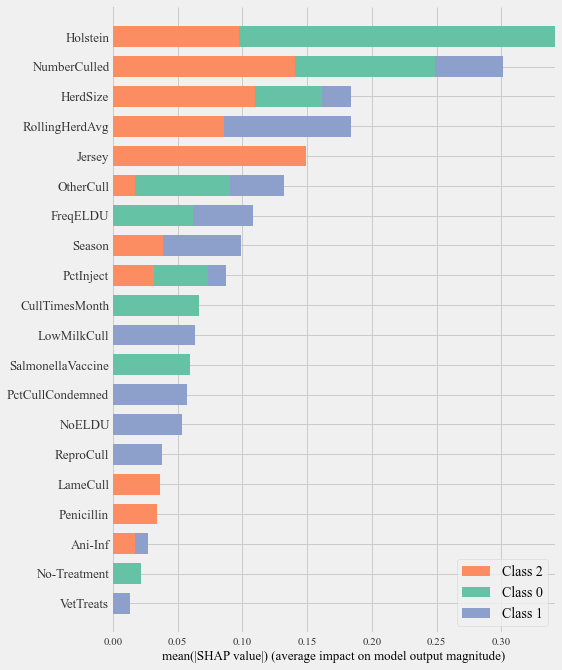

In [25]:
get_importance(data=data, y='Commensal_R', analysis_name='All_cows_commensal_R', color_list = ['#fc8d62', '#66c2a5','#8da0cb'], clf = commensal_clf)

### Entero resistance

In [26]:
entero_clf = XGBClassifier(colsample_bytree= 0.2, gamma= 0.2, learning_rate= 0.008,
                        max_depth= 8, min_child_weight= 1,
                         n_estimators= 10, objective= 'multi:softprob')

CullTimesMonth
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
PctCullCondemned
{0: 0, 1: 1, 2: 2, 3: 3}
PctInject
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
FreqELDU
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Season
{0: 0, 1: 1, 2: 2, 3: 3}
Fitting started


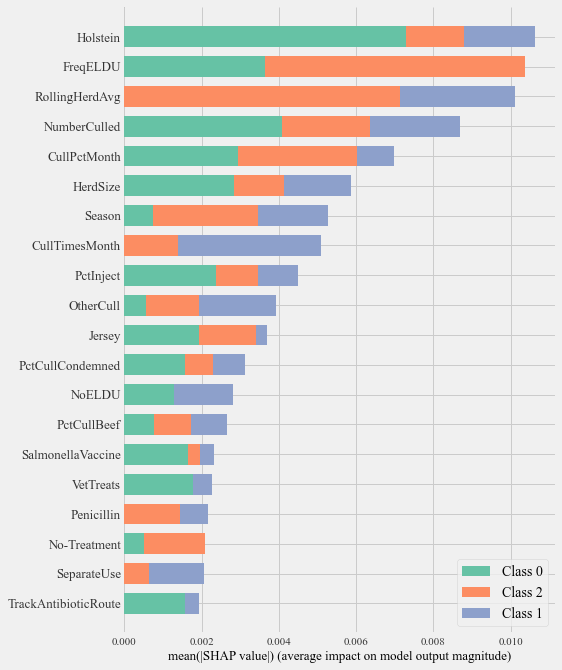

In [27]:
get_importance(data=data, y='Entero_R', analysis_name='All_cows_Entero_R', color_list = ['#66c2a5','#fc8d62', '#8da0cb'], clf = entero_clf)

### E coli resistance

In [28]:
ecoli_clf = XGBClassifier(colsample_bytree= 0.2, gamma= 0.1, learning_rate= 0.5,
                        max_depth= 8, min_child_weight= 1,
                         n_estimators= 30, objective= 'multi:softprob')

CullTimesMonth
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
PctCullCondemned
{0: 0, 1: 1, 2: 2, 3: 3}
PctInject
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
FreqELDU
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Season
{0: 0, 1: 1, 2: 2, 3: 3}
Fitting started


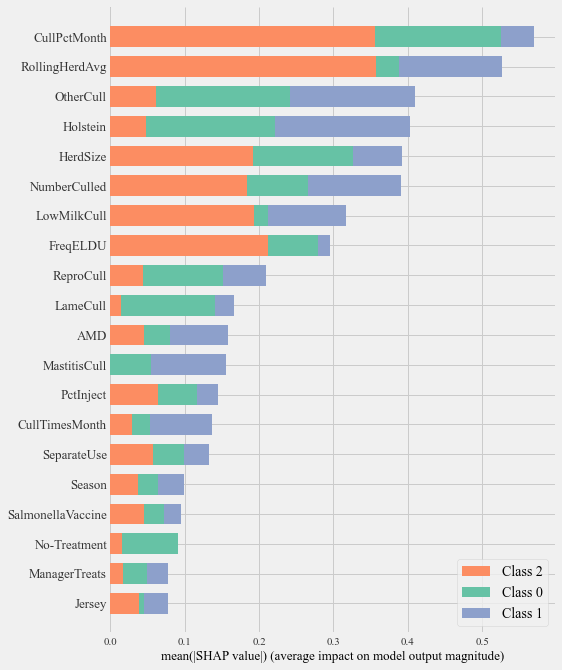

In [29]:
get_importance(data=data, y='Ecoli_R', analysis_name='All_cows_Ecoli_R', color_list = ['#fc8d62', '#66c2a5', '#8da0cb'], clf = ecoli_clf)

## Interactions

shap.dependence_plot("CullPctMonth", shap_values[0],data[cow_parameters+ herd_parameters])


shap.dependence_plot("CullTimesMonth", shap_values[1],data[cow_parameters+ herd_parameters])

shap.dependence_plot("CullTimesMonth", shap_values[2],data_m[cow_parameters+ herd_parameters])

In [30]:
cow_parameters

['LowMilkCull',
 'ReproCull',
 'LameCull',
 'MastitisCull',
 'OtherCull',
 'AMD',
 'Ani-Inf',
 'No-Treatment',
 'Other',
 'Tetracycline',
 'Penicillin',
 'Ceftiofur',
 'Season']

In [31]:
herd_parameters

['HerdSize',
 'RollingHerdAvg',
 'Holstein',
 'Jersey',
 'CullPctMonth',
 'CullTimesMonth',
 'MainCullReason',
 'PctCullBeef',
 'PctCullCondemned',
 'PctInject',
 'VetTreats',
 'ManagerTreats',
 'StaffTreats',
 'ResiduePrevent',
 'Chalk4Withdrawal',
 'Inventory',
 'SeparateUse',
 'CombinationUse',
 'TrackAntibioticDose',
 'TrackAntibioticRoute',
 'FamiliarELDU',
 'FreqELDU',
 'NoELDU',
 'NumberCulled',
 'SalmonellaVaccine']

### Salmonella positives only

In [22]:
sal_clf = XGBClassifier(colsample_bytree= 0.1, gamma= 0.1, learning_rate= 0.25,
                        max_depth= 3, min_child_weight= 3,
                         n_estimators= 5, objective= 'multi:softprob')

CullTimesMonth
{'0': 0, '1': 1, '1-2': 2, '1-3': 3, '1-4': 4, '2-4': 5}
PctCullCondemned
{'<1': 0, '<1-3': 1}
PctInject
{'10': 0, '10-20': 1, '<10': 2, '~10': 3, '~30': 4}
FreqELDU
{'0': 0, '10-20': 1, '2-5': 2, 'Variable': 3, '~5': 4}
Season
{'Autumn': 0, 'Spring': 1, 'Winter': 2}
Fitting started


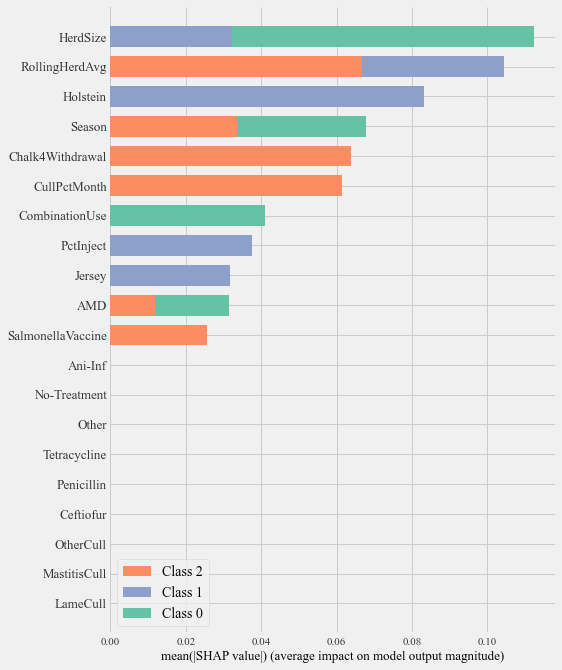

In [23]:
data_m = data[data['F_Salmonella PCR_Result'] == 'Positive']
get_importance(data=data_m, y='R_factor', analysis_name='SalPos_allMDR', color_list = ['#fc8d62','#8da0cb','#66c2a5'], clf = sal_clf)

## Prediction distribution through features: Salmonella positive cows only

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data_m[cow_parameters+ herd_parameters], data_m['R_factor'], test_size=0.33, random_state=42)
print ('Fitting started')
#best_xgb = XGBClassifier(colsample_bytree= 0.2, gamma= 0.0, learning_rate= 0.15,
#                             max_depth= 1, min_child_weight= 5, 
#                             n_estimators= 100, objective= 'multi:softprob')

xgb_salpos = sal_clf.fit(X = X_train, y = y_train)
import shap
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(xgb_salpos)
shap_values = explainer.shap_values(data_m[cow_parameters+ herd_parameters])

plt.rcParams['figure.figsize'] = 6, 4
def plot_pdp(feature, feature_name, class_number):
    pdp_feat_67_rf = pdp.pdp_isolate(
        model=xgb_salpos, dataset=data_m[cow_parameters+ herd_parameters],
        model_features=data_m[cow_parameters+ herd_parameters].columns, feature=feature
        )
    fig, axes = pdp.pdp_plot(
        pdp_isolate_out=pdp_feat_67_rf, feature_name=feature_name, center=True, x_quantile=True, 
        ncols=3, plot_lines=False, frac_to_plot=100,which_classes = [class_number], figsize=[6,6],
    )
    plt.tight_layout()
    axes['title_ax'].remove()
    return fig, axes['pdp_ax']

Fitting started


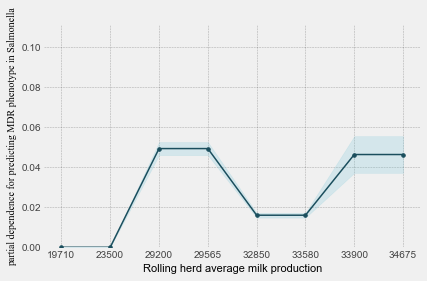

In [26]:
figure, axis = plot_pdp(feature= 'RollingHerdAvg', feature_name= 'RollingHerdAvg', class_number = 2)
axis.set_xlabel('Rolling herd average milk production')
axis.set_ylabel('partial dependence for predicting MDR phenotype in Salmonella', fontsize = 10)
plt.tight_layout()
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_sal/RollingHerdAvg.svg')

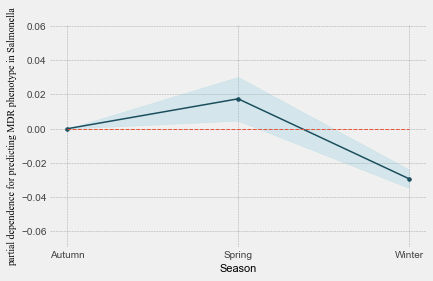

In [28]:
figure, axis = plot_pdp(feature= 'Season', feature_name= 'Season', class_number = 2)
_ = axis.set_xticklabels(['Autumn', 'Spring', 'Winter'])
axis.set_xlabel('Season')
axis.set_ylabel('partial dependence for predicting MDR phenotype in Salmonella', fontsize = 10)
plt.tight_layout()
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_sal/Season.svg')

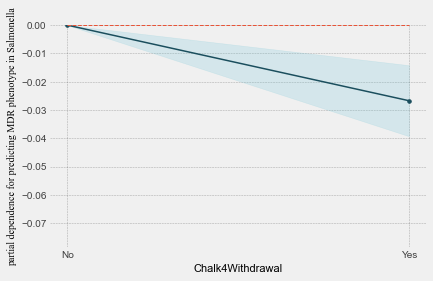

In [37]:
figure, axis = plot_pdp(feature= 'Chalk4Withdrawal', feature_name= 'Chalk4Withdrawal', class_number = 2)
_ = axis.set_xticklabels(['No', 'Yes'])
axis.set_xlabel('Chalk4Withdrawal')
axis.set_ylabel('partial dependence for predicting MDR phenotype in Salmonella', fontsize = 10)
plt.tight_layout()
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_sal/Chalk4Withdrawal.svg')

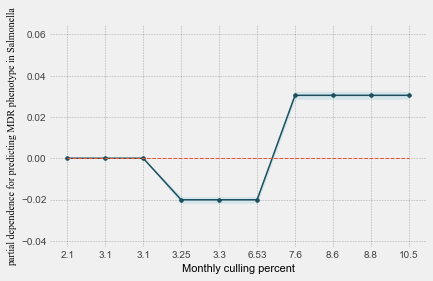

In [38]:
figure, axis = plot_pdp(feature= 'CullPctMonth', feature_name= 'CullPctMonth', class_number = 2)
axis.set_xlabel('Monthly culling percent')
axis.set_ylabel('partial dependence for predicting MDR phenotype in Salmonella', fontsize = 10)
plt.tight_layout()
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_sal/CullPctMonth.svg')

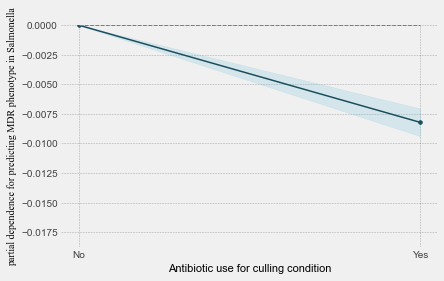

In [39]:
figure, axis = plot_pdp(feature= 'AMD', feature_name= 'AMD', class_number = 2)
_ = axis.set_xticklabels(['No', 'Yes'])
axis.set_xlabel('Antibiotic use for culling condition')
axis.set_ylabel('partial dependence for predicting MDR phenotype in Salmonella', fontsize = 10)
plt.tight_layout()
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_sal/AMD.svg')

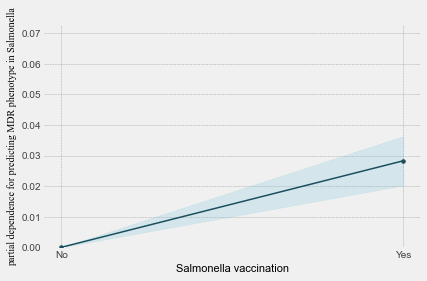

In [40]:
figure, axis = plot_pdp(feature= 'SalmonellaVaccine', feature_name= 'SalmonellaVaccine', class_number = 2)
_ = axis.set_xticklabels(['No', 'Yes'])
axis.set_xlabel('Salmonella vaccination')
axis.set_ylabel('partial dependence for predicting MDR phenotype in Salmonella', fontsize = 10)
plt.tight_layout(rect=[0, 0, 0.5, 1])
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_sal/SalmonellaVaccine.svg')

In [41]:
#get_importance(data=data, y='R_factor', analysis_name='All_cows')

In [42]:
data_m[cow_parameters+ herd_parameters].columns

Index(['LowMilkCull', 'ReproCull', 'LameCull', 'MastitisCull', 'OtherCull',
       'AMD', 'Ani-Inf', 'No-Treatment', 'Other', 'Tetracycline', 'Penicillin',
       'Ceftiofur', 'Season', 'HerdSize', 'RollingHerdAvg', 'Holstein',
       'Jersey', 'CullPctMonth', 'CullTimesMonth', 'MainCullReason',
       'PctCullBeef', 'PctCullCondemned', 'PctInject', 'VetTreats',
       'ManagerTreats', 'StaffTreats', 'ResiduePrevent', 'Chalk4Withdrawal',
       'Inventory', 'SeparateUse', 'CombinationUse', 'TrackAntibioticDose',
       'TrackAntibioticRoute', 'FamiliarELDU', 'FreqELDU', 'NoELDU',
       'NumberCulled', 'SalmonellaVaccine'],
      dtype='object')

## Prediction distribution through features: all cows

In [43]:
from sklearn import preprocessing
for c in categorical:
    le = preprocessing.LabelEncoder()
    le.fit(data[c])
    data[c] = le.transform(data[c]) 

for c in categorical:
    le = preprocessing.LabelEncoder()
    le.fit(data[c])
    data[c] = le.transform(data[c])
X_train, X_test, y_train, y_test = train_test_split(data[cow_parameters+ herd_parameters], data['R_factor'], test_size=0.33, random_state=42)
print ('Fitting started')
#all_clf = XGBClassifier(colsample_bytree= 0.4, gamma= 0.8, learning_rate= 0.5,
#                             max_depth= 4, min_child_weight= 3,
#                             n_estimators= 3, objective= 'multi:softprob')
xgb_all = all_clf.fit(X = X_train, y = y_train)
import shap
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(xgb_all)
shap_values = explainer.shap_values(data[cow_parameters+ herd_parameters])

plt.rcParams['figure.figsize'] = 6, 4
def plot_pdp(feature, feature_name, class_number):
    pdp_feat_67_rf = pdp.pdp_isolate(
        model=xgb_all, dataset=data[cow_parameters+ herd_parameters],
        model_features=data[cow_parameters+ herd_parameters].columns, feature=feature
        )
    fig, axes = pdp.pdp_plot(
        pdp_isolate_out=pdp_feat_67_rf, feature_name=feature_name, center=True, x_quantile=True, 
        ncols=3, plot_lines=False, frac_to_plot=1000, which_classes = [class_number], figsize=[6,6],
    )
    plt.tight_layout()
    axes['title_ax'].remove()
    return fig, axes['pdp_ax']

Fitting started


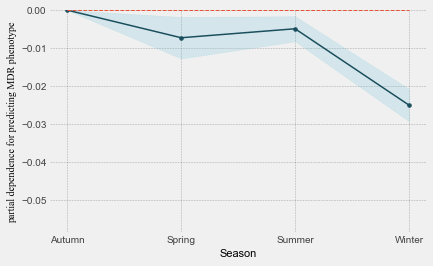

In [44]:
figure, axis = plot_pdp(feature= 'Season', feature_name= 'Season', class_number = 2)
_ = axis.set_xticklabels(['Autumn', 'Spring', 'Summer', 'Winter'])
axis.set_xlabel('Season')
axis.set_ylabel('partial dependence for predicting MDR phenotype', fontsize = 10)
plt.tight_layout()
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_all/Season_all.svg')

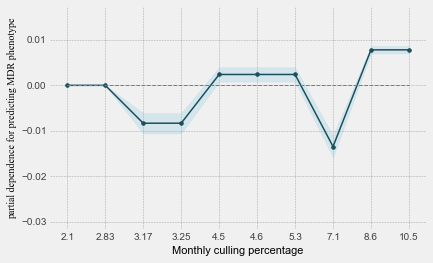

In [45]:
figure, axis = plot_pdp(feature= 'CullPctMonth', feature_name= 'CullPctMonth', class_number = 2)
axis.set_xlabel('Monthly culling percentage')
axis.set_ylabel('partial dependence for predicting MDR phenotype', fontsize = 10)
plt.tight_layout()
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_all/CullPctMonth_all.svg')

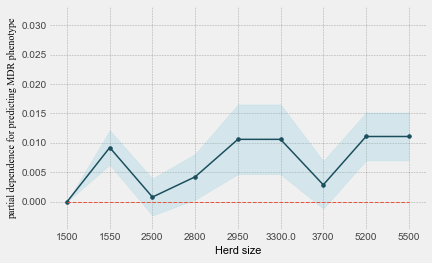

In [46]:
figure, axis = plot_pdp(feature= 'HerdSize', feature_name= 'HerdSize', class_number = 2)
axis.set_xlabel('Herd size')
axis.set_ylabel('partial dependence for predicting MDR phenotype', fontsize = 10)
plt.tight_layout()
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_all/HerdSize_all.svg')

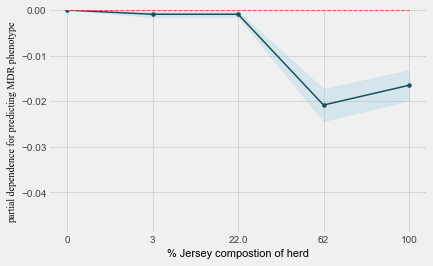

In [47]:
figure, axis = plot_pdp(feature= 'Jersey', feature_name= 'Jersey', class_number = 2)
axis.set_xlabel('% Jersey compostion of herd')
axis.set_ylabel('partial dependence for predicting MDR phenotype', fontsize = 10)
plt.tight_layout()
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_all/Jersey_all.svg')

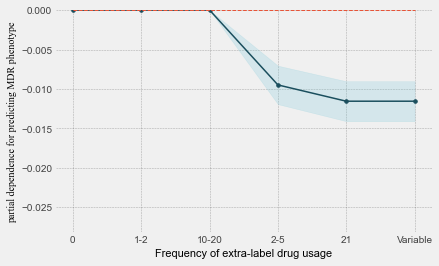

In [48]:
figure, axis = plot_pdp(feature= 'FreqELDU', feature_name= 'FreqELDU', class_number = 2)
_ = axis.set_xticklabels(['0', '1-2', '10-20', '2-5', '21', 'Variable', 'approx 5'])
axis.set_xlabel('Frequency of extra-label drug usage')
axis.set_ylabel('partial dependence for predicting MDR phenotype', fontsize = 10)
plt.tight_layout()
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_all/FreqELDU_all.svg')

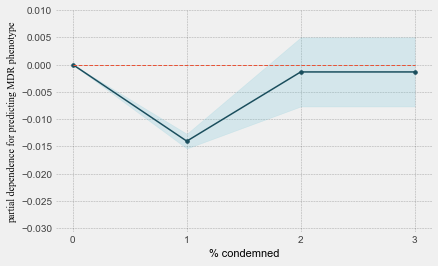

In [49]:
figure, axis = plot_pdp(feature= 'PctCullCondemned', feature_name= 'PctCullCondemned', class_number = 2)
axis.set_xlabel('% condemned')
axis.set_ylabel('partial dependence for predicting MDR phenotype', fontsize = 10)
plt.tight_layout()
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_all/PctCullCondemned_all.svg')

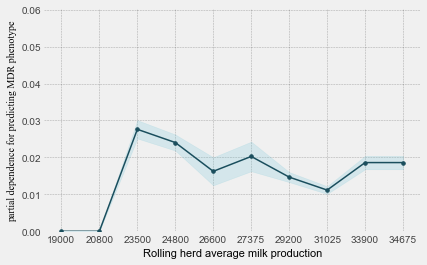

In [50]:
figure, axis = plot_pdp(feature= 'RollingHerdAvg', feature_name= 'RollingHerdAvg', class_number = 2)
axis.set_xlabel('Rolling herd average milk production')
axis.set_ylabel('partial dependence for predicting MDR phenotype', fontsize = 10)
plt.tight_layout()
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_all/RollingHerdAvg_all.svg')

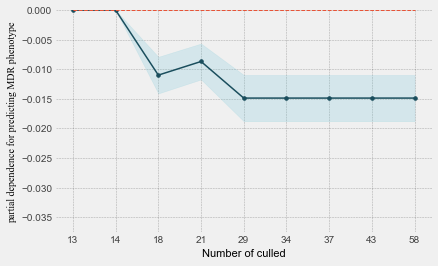

In [51]:
figure, axis = plot_pdp(feature= 'NumberCulled', feature_name= 'NumberCulled', class_number = 2)
axis.set_xlabel('Number of culled')
axis.set_ylabel('partial dependence for predicting MDR phenotype', fontsize = 10)
plt.tight_layout()
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_all/NumberCulled_all.svg')

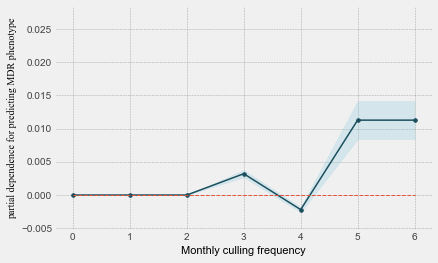

In [52]:
figure, axis = plot_pdp(feature= 'CullTimesMonth', feature_name= 'CullTimesMonth', class_number = 2)
axis.set_xlabel('Monthly culling frequency')
axis.set_ylabel('partial dependence for predicting MDR phenotype', fontsize = 10)
plt.tight_layout()
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_all/CullTimesMonth_all.svg')

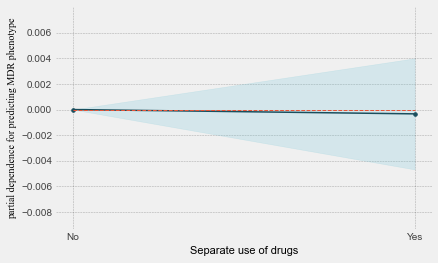

In [53]:
figure, axis = plot_pdp(feature= 'SeparateUse', feature_name= 'SeparateUse', class_number = 2)
_ = axis.set_xticklabels(['No', 'Yes'])
axis.set_xlabel('Separate use of drugs')
axis.set_ylabel('partial dependence for predicting MDR phenotype', fontsize = 10)
plt.tight_layout()
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_all/SeparateUse_all.svg')

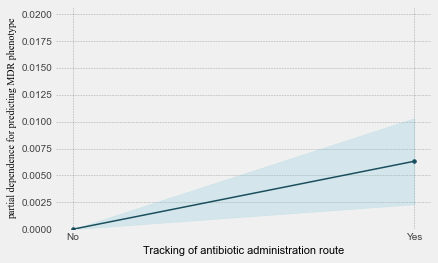

In [54]:
figure, axis = plot_pdp(feature= 'TrackAntibioticRoute', feature_name= 'TrackAntibioticRoute', class_number = 2)
_ = axis.set_xticklabels(['No', 'Yes'])
axis.set_xlabel('Tracking of antibiotic administration route')
axis.set_ylabel('partial dependence for predicting MDR phenotype', fontsize = 10)
plt.tight_layout()
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_all/TrackAntibioticRoute_all.svg')

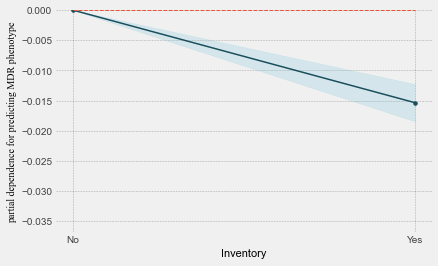

In [55]:
figure, axis = plot_pdp(feature= 'Inventory', feature_name= 'Inventory', class_number = 2)
_ = axis.set_xticklabels(['No', 'Yes'])
axis.set_xlabel('Inventory')
axis.set_ylabel('partial dependence for predicting MDR phenotype', fontsize = 10)
plt.tight_layout()
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_all/Inventory_all.svg')

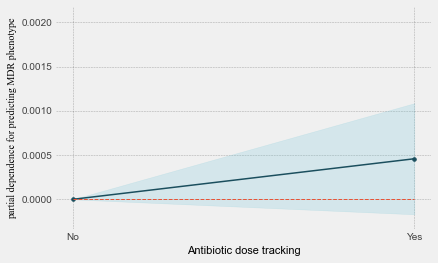

In [56]:
figure, axis = plot_pdp(feature= 'TrackAntibioticDose', feature_name= 'TrackAntibioticDose', class_number = 2)
_ = axis.set_xticklabels(['No', 'Yes'])
axis.set_xlabel('Antibiotic dose tracking')
axis.set_ylabel('partial dependence for predicting MDR phenotype', fontsize = 10)
plt.tight_layout()
plt.savefig('C:/Users/falco/Desktop/directory/Cattle_AMR_2/outputs/PDP_all/TrackAntibioticDose_all.svg')